In [32]:
import torch
import torchvision
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [33]:
# Set random seed for reproducibility
torch.manual_seed(42)

# 1. Data Preparation
# Convert images to tensors and normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 452kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.61MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.68MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [34]:
# 2. Define Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # The generator takes random noise and transforms it into images
        self.model = nn.Sequential(
            # Input: random noise vector (100 dimensions)
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),  # 28x28 = 784 (MNIST image size)
            nn.Tanh()  # Output values between -1 and 1
        )

    def forward(self, x):
        return self.model(x).view(-1, 1, 28, 28)  # Reshape to image format

In [35]:
# 3. Define Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # The discriminator tries to distinguish real from fake images
        self.model = nn.Sequential(
            # Input: 28x28 image
            nn.Flatten(),  # Flatten the image
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output probability between 0 and 1
        )

    def forward(self, x):
        return self.model(x)

In [36]:
# 4. Initialize networks and optimizers
generator = Generator()
discriminator = Discriminator()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
criterion = nn.BCELoss()

In [38]:
# 5. Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.size(0)

        # Create labels for real and fake images
        real_label = torch.ones(batch_size, 1)
        fake_label = torch.zeros(batch_size, 1)

        # Train Discriminator
        d_optimizer.zero_grad()
        # Train with real images
        output_real = discriminator(real_images)
        d_loss_real = criterion(output_real, real_label)

        # Train with fake images
        noise = torch.randn(batch_size, 100)  # Generate random noise
        fake_images = generator(noise)
        output_fake = discriminator(fake_images.detach())
        d_loss_fake = criterion(output_fake, fake_label)

        # Combined discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        output_fake = discriminator(fake_images)
        g_loss = criterion(output_fake, real_label)  # Try to fool discriminator
        g_loss.backward()
        g_optimizer.step()

        # Print progress
        if i % 100 == 0:
            print(f'Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] '
                  f'D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}')

    # Save generated images every 10 epochs
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            fake_images = generator(torch.randn(16, 100))
            fake_images = fake_images.reshape(-1, 28, 28)

            plt.figure(figsize=(4, 4))
            for j in range(16):
                plt.subplot(4, 4, j+1)
                plt.imshow(fake_images[j], cmap='gray')
                plt.axis('off')
            plt.savefig(f'fake_images_epoch_{epoch+1}.png')
            plt.close()

print("Training finished!")

Epoch [0/20] Batch [0/938] D_loss: 0.5829 G_loss: 2.8170
Epoch [0/20] Batch [100/938] D_loss: 0.3054 G_loss: 2.5551
Epoch [0/20] Batch [200/938] D_loss: 0.1751 G_loss: 4.7197
Epoch [0/20] Batch [300/938] D_loss: 0.6221 G_loss: 2.0115
Epoch [0/20] Batch [400/938] D_loss: 1.6606 G_loss: 1.9131
Epoch [0/20] Batch [500/938] D_loss: 0.7650 G_loss: 2.1764
Epoch [0/20] Batch [600/938] D_loss: 0.3211 G_loss: 3.2890
Epoch [0/20] Batch [700/938] D_loss: 0.5140 G_loss: 2.6009
Epoch [0/20] Batch [800/938] D_loss: 0.4003 G_loss: 2.5144
Epoch [0/20] Batch [900/938] D_loss: 2.3362 G_loss: 1.5130
Epoch [1/20] Batch [0/938] D_loss: 0.0762 G_loss: 4.3647
Epoch [1/20] Batch [100/938] D_loss: 0.1388 G_loss: 3.5191
Epoch [1/20] Batch [200/938] D_loss: 0.7826 G_loss: 1.6239
Epoch [1/20] Batch [300/938] D_loss: 0.6030 G_loss: 2.6072
Epoch [1/20] Batch [400/938] D_loss: 0.7766 G_loss: 2.8863
Epoch [1/20] Batch [500/938] D_loss: 0.2781 G_loss: 3.7995
Epoch [1/20] Batch [600/938] D_loss: 0.2974 G_loss: 3.0016
E

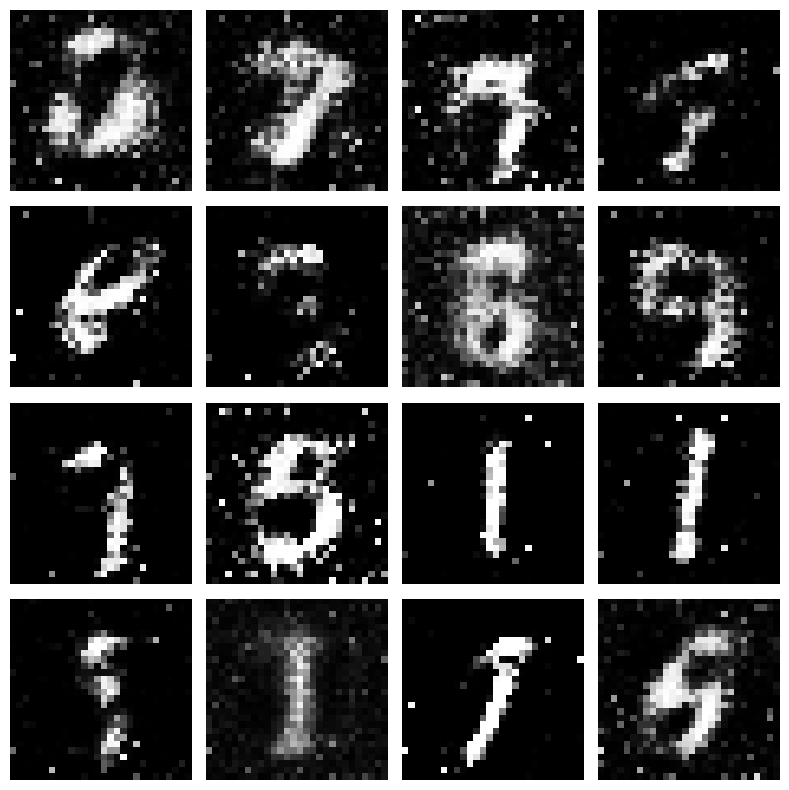

In [39]:
# Function to generate and display final images
def show_final_images(generator, num_images=16):
    with torch.no_grad():
        # Generate random noise
        noise = torch.randn(num_images, 100)
        # Generate images
        fake_images = generator(noise)
        fake_images = fake_images.reshape(-1, 28, 28)

        # Create subplot
        plt.figure(figsize=(8, 8))
        for i in range(num_images):
            plt.subplot(4, 4, i+1)
            plt.imshow(fake_images[i].cpu().numpy(), cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# Display final generated images
show_final_images(generator)